# Image Captioning
We will be emulating "Show Attend and Tell" on Flickr 8k dataset. We will be following the [tutorial](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning). Note: We will add proper explanations at each step to make it a self contained guide.

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Our dataset consisits of Images and text. Each Image has 5 captions associated with it in the form of imageid caption. Now we need to do some major data processing. Firstly our 

In [68]:
path = '../input/flickr8k/Flickr_Data/Flickr_Data'
text_path = path+'/Flickr_TextData'
images_path = path+'/Images'
captions_path = text_path+'/Flickr8k.token.txt'
train_path = text_path+'/Flickr_8k.trainImages.txt'
val_path = text_path+'/Flickr_8k.devImages.txt'
test_path = text_path+'/Flickr_8k.testImages.txt'
images_dir = os.listdir(path+'/Images')


In [69]:
def show_image(img_path):
    k = cv2.imread(path+'/Images/'+img_path)
    k = cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(k)

In [70]:
captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [71]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]


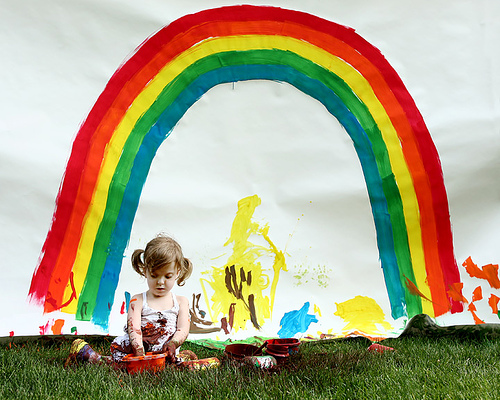

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [72]:
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+'/'+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

## Preparing Caption Dataset
We need to create a vocabulary for all the words that are present in the image caption dataset. Once we have that the next step is to create our caption vectors. To do that we first choose
+ Length of the caption
+ Frequency of the words  

We want to pad the sentences upto the max length (213) with `<pad>` token. 
Once that is done, we decide the threshold of the frequency of the words. If the word has lower count than some threshold it is replaced by `<unk>` keyword. Therefore each caption is supposed to look like -   
`<start> A little girl is sitting in <unk> front of a large <unk> rainbow . <end> <pad> <pad> <pad> ....` where we assume frequency of `front` and `painted` is less than the threshold.  
Once we have done that the next step is to tokenize the vectors. This is nothing but just substituting the words with some number. So `little` could be represented by 43. Note keep `<pad>` as 0 for implementation purposes  
Therefore, captions fed to the model must be an Int tensor of dimension N, L where L is the padded length.
caption lengths fed to the model must be an Int tensor of dimension N.

### Observations
+ Over 6% captions have length > 100. For the purpose of learning we dont tinker with that
+ Over 42% words have a frequency of 1. Technically we should set a threshold but the score could be severely affected if we use `<unk>`. Thus we dont make those changes

In [73]:
start = '<start> '
end = ' <end>'
cap_train = []
for img in x_train:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_train +=  caption
cap_val = []

for img in x_val:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_val +=  caption
cap_test = []

for img in x_test:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_test +=  caption
    

In [74]:
all_captions = cap_train +cap_val + cap_test
all_captions[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

### Creating Vocabulary

In [75]:
from collections import Counter
sent = [k.split(' ') for k in all_captions]
sentences = [y for x in sent for y in x]

count_words = Counter(sentences)

In [76]:
min_threshold = 0
words = [w for w in count_words.keys() if count_words[w] > min_threshold]
#unk_words = [w for w in count_words.keys() if count_words[w] < min_threshold]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 3
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 2
word_map['<pad>'] = 0

In [77]:
def word2ind(x):
    if x in word_map.keys():
        return word_map[x]
    else:
        return word_map['<unk>']

Token train is the list of captions that will be used for training

In [78]:
max_len = 40
tokenized_dataset = {}
splits = ['train','val','test']
caption_split = [cap_train, cap_val,cap_test]
for i,split in enumerate(splits):
    token_caption = []
    token_caption_len = []
    for cap in caption_split[i]:
        s = list(map(word2ind,cap.split(' ')))
        token_caption.append(list(s) + [word_map['<pad>']]*(max_len-len(s)))
        token_caption_len.append(len(cap.split(' ')))
    tokenized_dataset[split] = [token_caption,token_caption_len]


## Creating Pytorch Dataset

In [79]:
import torch
from torch.utils.data import Dataset

In [80]:
def readImg(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    return img 

In [81]:
class CaptionDataset(Dataset):
    def __init__(self,img_dir,img_list,captions,split,transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.split = split
        self.captions = captions[0]
        self.captions_length = captions[1]
        self.transform = transform
        self.cpi = 5
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = readImg(self.img_dir+'/'+self.img_list[i//self.cpi])
        img = torch.FloatTensor(img / 255.)
#         img = img/255.0
        if self.transform is not None:
            img = img.permute((2,0,1))
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.captions_length[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

In [82]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset


transforms_train = transforms.Compose([
#     transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_data = CaptionDataset(images_path, x_train, tokenized_dataset['train'],'TRAIN',transform=transforms.Compose([normalize]))
val_data = CaptionDataset(images_path, x_val, tokenized_dataset['val'],'VAL',transform=transforms.Compose([normalize]))
test_data = CaptionDataset(images_path, x_test, tokenized_dataset['test'],'TEST',transform=transforms.Compose([normalize]))

In [96]:
batch = 64
train_loader = DataLoader(train_data,batch_size=batch, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data,batch_size=batch, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=1, shuffle=True, pin_memory=True)

## Model
### Encoder
We now define the model architecture. In very crude terms it is a encoder decoder architecture where encoder will encode the image features and the decoder will use those features to extract the caption. 
The encoder returns a tensor of size `2048x14x14`. This is then the input to our decoder based LSTM.
![Encoder](https://raw.githubusercontent.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/master/img/encoder.png)

In [84]:
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
class Encoder(nn.Module):
    
    def __init__(self,encoded_image_size=14,fine_tune=True):
        super(Encoder,self).__init__()
        self.enc_size = encoded_image_size
        resnet = torchvision.models.resnet101(pretrained=True)
#         We remove the linear and pool layers at the end since we are not doing classification
        modules = list(resnet.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(self.enc_size)
        
        self.fine_tune(fine_tune)
    
    def forward(self,x):
        bp = self.model(x) # (batch,2048,img/32,img/32)
        ap = self.pool(bp) # (batch, 2048,enc_img_size,enc_img_size)
        out = ap.permute(0,2,3,1) #(batch,enc_img_size,enc_img_size,2048)
        return out
    
    def fine_tune(self,fine_tune=True):
        for p in self.model.parameters():
            p.requires_grad = False
#         If we fine tune then we only do with conv layers through blocks 2 to 4
        for c in list(self.model.children())[5:]:
            for p in c.parameters():
                p.requires_grad = True

Our decoder consists of a long list of LSTMs. The Decoder's job is to look at the encoded image and generate a caption word by word.  
In a typical setting without Attention, you could simply average the encoded image across all pixels. You could then feed this, with or without a linear transformation, into the Decoder as its first hidden state and generate the caption. Each predicted word is used to generate the next word.  
![Without Attention](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/raw/master/img/decoder_no_att.png)

With setting, the word takes the image into account as well. Thus instead of simple average we take weighted average focussing on the word in question.
![Attention](https://raw.githubusercontent.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/master/img/decoder_att.png)

### Attention
This part is the one which tells where the decoder should look before predicting any word. We use soft attention where the pixels add upto 1.  This could be interpreted as the probability that the given pixel is the place to look at to generate the word.
![](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/raw/master/img/weights.png)

In [86]:
class Attention(nn.Module):
    def __init__(self,encoder_dim,decoder_dim,attention_dim):
        """
        encoder_dim : size of encoded images
        decoder_dim : size of decoder RNNs
        attention_dim : size of the attention network
        """
        super(Attention,self).__init__()
        self.encoder_att = nn.Linear(encoder_dim,attention_dim)
        self.decoder_att = nn.Linear(decoder_dim,attention_dim)
        self.full_att = nn.Linear(attention_dim,1)#linear layer to calculate the value to be softmaxed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)# softmax layer to calculate the weights
        
    def forward(self,encoder_out,decoder_hidden):
        """
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out) 
        att2 = self.decoder_att(decoder_hidden)
        att_full = self.full_att(att1+att2.unsqueeze(1)).squeeze(2) #(batch,num_pixels)
        alpha = self.softmax(att_full) #(batch,num_pixels)
        attention_weighted_encoding = (encoder_out* alpha.unsqueeze(2)).sum(dim=1) #(batch_size,encoder_dim)
        
        return attention_weighted_encoding, alpha
        
        

### Decoder
* Once the Encoder generates the encoded image, we transform the encoding to create the initial hidden state h (and cell state C) for the LSTM Decoder.
* At each decode step,  
    the encoded image and the previous hidden state is used to generate weights for each pixel in the Attention network.  
    the previously generated word and the weighted average of the encoding are fed to the LSTM Decoder to generate the next word.  

![](https://raw.githubusercontent.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/master/img/model.png)

In [87]:
class Decoder(nn.Module):
    def __init__(self,attention_dim,embed_dim, decoder_dim, vocab_size,encoder_dim = 2048, dropout = 0.5):
        super(Decoder,self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
#         self.dropout = dropout
        
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        self.embedding = nn.Embedding(vocab_size,embed_dim) #embedding layer
        self.dropout = nn.Dropout(p=dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial hidden layer in LSTM
        self.init_c = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial cell layer in LSTM
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) #linear layer to find create a sigmoid-activated gate
        
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size) #linear layer to find scores over vocabulary
        self.init_weights()
        
    def init_weights(self):
        """
        Initialization over uniform distribution
        """
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1,0.1)

    def load_pretrained_embeddings(self,embedding):
        """
        Loads pretrained embeddings
        """
        self.embedding.weight = nn.Parameter(embedding)
    def fine_tune_embeddings(self,fine_tune=True):
        """
        Unless using pretrained embeddings, keep it true
        """
        for p in self.embedding.parameters():
            p.requires_grad=fine_tune
            
    def init_hidden_state(self,encoder_out):
        """
        Creates initial hidden and cell state of the LSTM based on the encoded images.
        :encoder_out : encoded images, a tensor of dimension(batch_size, num_of_pixels,encoder_dim)
        :return hidden and cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out) #(batch_size,decoder_dim) output
        c = self.init_c(mean_encoder_out)
        return h,c
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
            


### Creating Util functions
We create some utility functions such as loading pretrained word embeddings, computing measures, etc.

In [88]:
def init_embeddings(embeddings):
    """
    Fills embeddings with uniform information
    """
    bias = np.sqrt(3.0/embeddings.size(1))
    torch.nn.init.uniform_(embeddings,-bias,bias)

def load_embeddings(emb_file,word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """
    with open(emb_file,'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1
    vocab = set(word_map.keys())
    
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embeddings(embeddings)
    
    print("Loading embeddings")
    for line in open(emb_file,'r'):
        line = line.split(' ')
        
        emb_words = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))
        
        if emb_file not in vocab:
            continue
        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)
    return embeddings, emb_dim

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients during backprop
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip,grad_clip)
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

### Training the Model
We now set the variables and with all our pieces intact we can start training

In [89]:
# Model Parameters
emb_dim = 512
attention_dim = 512
decoder_dim = 512
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cudnn.benchmark = True #set to True if inputs to model are fixed size

#Training Parameters
start_epoch = 0
epochs = 32
epochs_since_improvement = 0
batch_size = 64
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 5.0
alpha_c = 1.0 #will be used in doubly attention loss part
best_bleu4 = 0
print_freq = 100
fine_tune_encoder = False
checkpoint = None

In [90]:
decoder = Decoder(attention_dim=attention_dim,
                 embed_dim = emb_dim,
                 decoder_dim=decoder_dim,
                 vocab_size = len(word_map)+2,
                 dropout=dropout)
optim_decoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
optim_encoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None
decoder.to(device)
encoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

### Training Loop

In [91]:
from torch.nn.utils.rnn import pack_padded_sequence
import time
def train(train_loader,encoder, decoder, criterion, optim_encoder, optim_decoder,epoch):
    decoder.train()
    encoder.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5acc = AverageMeter()
    
    start = time.time()
    
    for i , (imgs,caps,caplens) in enumerate(train_loader):
        data_time.update(time.time()-start)
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        #Forward Prop
        
        imgs = encoder(imgs)
        scores,cap_sorted, decode_lengths, alphas, sort_ind = decoder(imgs,caps,caplens)
        
        targets = cap_sorted[:,1:]
        
        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss = criterion(scores,targets)
        
        #Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        #Backprop
        optim_decoder.zero_grad()
        if optim_encoder:
            optim_encoder.zero_grad()
        loss.backward()
        
        if grad_clip:
            clip_gradient(optim_decoder,grad_clip)
            if optim_encoder:
                clip_gradient(optim_encoder,grad_clip)
        
        #Update weights
        optim_decoder.step()
        if optim_encoder:
            optim_encoder.step()
        
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5acc.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5acc))

### Validation Loop

In [92]:
from nltk.translate.bleu_score import corpus_bleu
def validate(val_loader, encoder,decoder, criterion):
    decoder.eval()
    if encoder:
        encoder.eval()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores  = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets  = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4*100))

    return bleu4

In [93]:
from tqdm import tqdm
for epoch in tqdm(range(start_epoch,epochs)):
    if epochs_since_improvement > 8:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)
    train(train_loader,encoder,decoder,criterion,optim_encoder,optim_decoder,epoch)
    recent_bleu4 = validate(val_loader,encoder,decoder,criterion)
    is_best = recent_bleu4 > best_bleu4
    if recent_bleu4 > best_bleu4:
        best_bleu4 = recent_bleu4
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    save_checkpoint('caption_model', epoch, epochs_since_improvement, encoder, decoder, optim_encoder,
                        optim_decoder, recent_bleu4, is_best)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [0][0/469]	Batch Time 1.517 (1.517)	Data Load Time 0.686 (0.686)	Loss 10.0995 (10.0995)	Top-5 Accuracy 0.128 (0.128)
Epoch: [0][100/469]	Batch Time 1.441 (1.534)	Data Load Time 0.623 (0.687)	Loss 5.3134 (6.2970)	Top-5 Accuracy 46.608 (37.859)
Epoch: [0][200/469]	Batch Time 1.457 (1.536)	Data Load Time 0.630 (0.688)	Loss 5.0394 (5.7856)	Top-5 Accuracy 53.102 (42.738)
Epoch: [0][300/469]	Batch Time 1.492 (1.533)	Data Load Time 0.606 (0.684)	Loss 4.7996 (5.4943)	Top-5 Accuracy 55.543 (46.299)
Epoch: [0][400/469]	Batch Time 1.459 (1.532)	Data Load Time 0.628 (0.684)	Loss 4.4817 (5.2864)	Top-5 Accuracy 58.364 (48.882)
Validation: [0/79]	Batch Time 0.945 (0.945)	Loss 4.6400 (4.6400)	Top-5 Accuracy 56.059 (56.059)	

 * LOSS - 4.418, TOP-5 ACCURACY - 59.677, BLEU-4 - 12.460477054215648



/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
100%|██████████| 1/1 [13:18<00:00, 798.22s/it]


In [103]:
import torch.nn.functional as F
def evaluate(beam_size,loader):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    

    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            vocab_size = len(word_map)+2
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        try:
            
            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        except:
            i=0

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses)

    return bleu4


In [104]:
beam_size=1
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, evaluate(beam_size,test_loader))*100)

EVALUATING AT BEAM SIZE 1: 100%|██████████| 5000/5000 [04:24<00:00, 18.93it/s]



BLEU-4 score @ beam size of 1 is 0.1407.


In [ ]:
print("\nBLEU-4 score @ beam size of %d is %.4f." % (3, evaluate(3,test_loader))*100)

EVALUATING AT BEAM SIZE 3:  18%|█▊        | 885/5000 [00:50<03:45, 18.24it/s]

We complete show attend and tell with this. Special thanks to [sagar vinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) for this amazing tutorial. Will be improved upon with Glove and better embeddings 